In [1]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

import datetime as dt
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import kagglehub
from datasets import load_dataset

if 'pygents.aigents_api' in sys.modules:
    del sys.modules['pygents.aigents_api']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']
if 'pygents.recognition_evaluators' in sys.modules:
    del sys.modules['pygents.recognition_evaluators']

from pygents.recognition_evaluators import evaluate_tm_df, our_evaluator_true, our_evaluator_false
from pygents.recognition_evaluators import our_evaluator_top, our_evaluator_top1, language_metrics
from pygents.util import dictcount, dict_compress_with_loss
from pygents.aigents_api import TextMetrics
from pygents.plot import plot_bar_from_list_minmax


[nltk_data] Downloading package punkt to /Users/akolonin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Check/get/fix datasets

In [2]:
# English corpus

# Download latest version
path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")

print("Path to dataset files:", path)


df_en = pd.read_csv(path+'/Annotated_data.csv') 
df_en = df_en.drop('Id_Number', axis=1) # delete columnb with id 

df_en

Path to dataset files: /Users/akolonin/.cache/kagglehub/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset/versions/1


,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,Since I was about 16 years old I’ve had these ...,I feel trapped inside my disgusting self and l...,Labeling,Emotional Reasoning
2,So I’ve been dating on and off this guy for a...,NaN,No Distortion,NaN
3,My parents got divorced in 2004. My mother has...,NaN,No Distortion,NaN
4,I don’t really know how to explain the situati...,I refused to go because I didn’t know if it wa...,Fortune-telling,Emotional Reasoning
...,...,...,...,...
2525,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
2526,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
2527,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
2528,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


In [3]:
#check that distorted text is present only if there is a distortion present  
for index, row in df_en.iterrows():
    if type(row['Distorted part']) != str:
        if row['Dominant Distortion'] != 'No Distortion':
            print(index)
    if type(row['Distorted part']) == str:
        if row['Dominant Distortion'] == 'No Distortion':
            print(index,row['Dominant Distortion'])


In [4]:
# English corpus

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("psytechlab/cognitive_distortions_dataset_ru")

In [5]:
df_ru = pd.DataFrame(ds["train"])
df_ru

,id,patient_question,patient_question_rus,distorted_part,distorted_part_rus,dominant_distortion,secondary_distortion
0,4500,"Hello, I have a beautiful,smart,outgoing and a...","Здравствуйте, у меня есть красивая, умная, общ...",[The voice are always fimilar (someone she kno...,"[Голоса всегда знакомы (кто-то, кого она знает...",Personalization,No Distortion
1,4501,Since I was about 16 years old I’ve had these ...,"С 16 лет у меня бывают такие «приступы», когда...",[I feel trapped inside my disgusting self and ...,[Я чувствую себя запертым в своем отвратительн...,Labeling,Emotional Reasoning
2,4502,So I’ve been dating on and off this guy for al...,"Итак, я встречаюсь с этим парнем то встречаюсь...",[],[],No Distortion,No Distortion
3,4503,My parents got divorced in 2004. My mother has...,Мои родители развелись в 2004 году. Моя мама т...,[],[],No Distortion,No Distortion
4,4504,I don’t really know how to explain the situati...,"Я действительно не знаю, как объяснить ситуаци...",[I refused to go because I didn’t know if it w...,"[Я отказался идти, потому что не знал, пойдет ...",Fortune-telling,Emotional Reasoning
...,...,...,...,...,...,...,...
2520,2562,I’m a 21 year old female. I spent most of my l...,"Мне 21 год, я девушка. Большую часть своей жиз...",[],[],No Distortion,No Distortion
2521,2563,I am 21 female and have not had any friends fo...,"Мне 21 год, я девушка, и у меня не было друзей...",[Now I am at university my peers around me all...,"[Сейчас, когда я в университете, мои сверстник...",Overgeneralization,No Distortion
2522,2564,From the U.S.: My brother is 19 years old and ...,"Из США: Моему брату 19 лет, и он сейчас живет ...",[He claims he’s severely depressed and has out...,"[Он утверждает, что у него тяжелая депрессия, ...",Mental filter,Mind Reading
2523,2565,From the U.S.: I am a 21 year old woman who ha...,"Из США: Мне 21 год, и я серьезно вовлечена в о...",[],[],No Distortion,No Distortion


In [6]:
# Russian corpus

df_ru = df_ru.drop(['id','patient_question','distorted_part'], axis=1) # delete columnb with id 
df_ru

,patient_question_rus,distorted_part_rus,dominant_distortion,secondary_distortion
0,"Здравствуйте, у меня есть красивая, умная, общ...","[Голоса всегда знакомы (кто-то, кого она знает...",Personalization,No Distortion
1,"С 16 лет у меня бывают такие «приступы», когда...",[Я чувствую себя запертым в своем отвратительн...,Labeling,Emotional Reasoning
2,"Итак, я встречаюсь с этим парнем то встречаюсь...",[],No Distortion,No Distortion
3,Мои родители развелись в 2004 году. Моя мама т...,[],No Distortion,No Distortion
4,"Я действительно не знаю, как объяснить ситуаци...","[Я отказался идти, потому что не знал, пойдет ...",Fortune-telling,Emotional Reasoning
...,...,...,...,...
2520,"Мне 21 год, я девушка. Большую часть своей жиз...",[],No Distortion,No Distortion
2521,"Мне 21 год, я девушка, и у меня не было друзей...","[Сейчас, когда я в университете, мои сверстник...",Overgeneralization,No Distortion
2522,"Из США: Моему брату 19 лет, и он сейчас живет ...","[Он утверждает, что у него тяжелая депрессия, ...",Mental filter,Mind Reading
2523,"Из США: Мне 21 год, и я серьезно вовлечена в о...",[],No Distortion,No Distortion


In [7]:
#check that distorted text is present only if there is a distortion present  
for index, row in df_ru.iterrows():
    if len(row['distorted_part_rus']) == 0:
        #print(index,row['dominant_distortion'],row['distorted_part_rus'])
        if row['dominant_distortion'] != 'No Distortion':
            print(index)
    if len(row['distorted_part_rus']) != 0:
        if row['dominant_distortion'] == 'No Distortion':
            print(index)

In [8]:
def join_phrases(lst):
    lst = [x+"." if not x[-1] in ".!?" else x for x in lst]
    return " ".join(lst)
assert(join_phrases(["aaa!","bbb?","ccc.","ddd"])=='aaa! bbb? ccc. ddd.')

join_phrases(["aaa!","bbb?","ccc.","ddd"])


'aaa! bbb? ccc. ddd.'

In [9]:
for index, row in df_ru.iterrows():
    if len(row['distorted_part_rus']) > 2:
        x = row['distorted_part_rus']
        print(x)
        print(join_phrases(x))
        break


['Я отказался идти, потому что не знал, пойдет ли это в мое досье, что потенциально могло бы повлиять на мои мечты стать психиатром.', 'Я очень боюсь удушья и утопления', 'Кажется, каждый раз, когда я так близок к победе над этим, я снова оказываюсь на дне.']
Я отказался идти, потому что не знал, пойдет ли это в мое досье, что потенциально могло бы повлиять на мои мечты стать психиатром. Я очень боюсь удушья и утопления. Кажется, каждый раз, когда я так близок к победе над этим, я снова оказываюсь на дне.


In [10]:
df_ru['distorted_part_rus'] = df_ru['distorted_part_rus'].transform(join_phrases)


In [11]:
df = df_ru
df

,patient_question_rus,distorted_part_rus,dominant_distortion,secondary_distortion
0,"Здравствуйте, у меня есть красивая, умная, общ...","Голоса всегда знакомы (кто-то, кого она знает)...",Personalization,No Distortion
1,"С 16 лет у меня бывают такие «приступы», когда...",Я чувствую себя запертым в своем отвратительно...,Labeling,Emotional Reasoning
2,"Итак, я встречаюсь с этим парнем то встречаюсь...",,No Distortion,No Distortion
3,Мои родители развелись в 2004 году. Моя мама т...,,No Distortion,No Distortion
4,"Я действительно не знаю, как объяснить ситуаци...","Я отказался идти, потому что не знал, пойдет л...",Fortune-telling,Emotional Reasoning
...,...,...,...,...
2520,"Мне 21 год, я девушка. Большую часть своей жиз...",,No Distortion,No Distortion
2521,"Мне 21 год, я девушка, и у меня не было друзей...","Сейчас, когда я в университете, мои сверстники...",Overgeneralization,No Distortion
2522,"Из США: Моему брату 19 лет, и он сейчас живет ...","Он утверждает, что у него тяжелая депрессия, и...",Mental filter,Mind Reading
2523,"Из США: Мне 21 год, и я серьезно вовлечена в о...",,No Distortion,No Distortion


In [12]:
all_dists = {}
for _, row in df.iterrows():
    # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
    text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
    primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
    secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists
    dictcount(all_dists,primary_distortion)
    if not secondary_distortion is None:
        dictcount(all_dists,secondary_distortion)
print(all_dists)
del all_dists['No Distortion']
all_dists

{'Personalization': 201, 'No Distortion': 3043, 'Labeling': 203, 'Emotional Reasoning': 168, 'Fortune-telling': 209, 'Magnification': 244, 'Mind Reading': 295, 'All-or-nothing thinking': 125, 'Overgeneralization': 277, 'Mental filter': 150, 'Should statements': 135}


{'Personalization': 201,
 'Labeling': 203,
 'Emotional Reasoning': 168,
 'Fortune-telling': 209,
 'Magnification': 244,
 'Mind Reading': 295,
 'All-or-nothing thinking': 125,
 'Overgeneralization': 277,
 'Mental filter': 150,
 'Should statements': 135}

In [13]:
split_shifts = [0,1,2]
eval_results = []
validation_fraction = 3
for split_shift in split_shifts:
    test_df  = df[(df.index + split_shift) % validation_fraction == 0]
    print(len(test_df))


842
841
842


## Re-evaluate all models on full Russian dataset

In [14]:
all_eval_results = {}

In [15]:
    eval_results = []
    for split_shift in split_shifts:
        test_df  = df[(df.index + split_shift) % validation_fraction == 0]
        eval_result = evaluate_tm_df(test_df,None,our_evaluator_true,None,all_metrics=all_dists,encode_spaces=False,debug=False)
        eval_results.append(eval_result)

    #for eval_result in eval_results:
    #    print(eval_result[2]) # F1

    prs = [sum(eval_result[0].values())/len(eval_result[0].values()) for eval_result in eval_results]
    rcs = [sum(eval_result[1].values())/len(eval_result[1].values()) for eval_result in eval_results]
    f1s = [sum(eval_result[2].values())/len(eval_result[2].values()) for eval_result in eval_results]
    pravg = sum(prs)/3
    rcavg = sum(rcs)/3
    f1avg = sum(f1s)/3
    print('N/A',round(pravg,2),round(rcavg,2),round(f1avg,2),[round(x,2) for x in f1s])

    all_eval_results['Const(True)'] = eval_results


N/A 0.08 1.0 0.15 [0.15, 0.15, 0.14]


In [16]:
    eval_results = []
    for split_shift in split_shifts:
        test_df  = df[(df.index + split_shift) % validation_fraction == 0]
        eval_result = evaluate_tm_df(test_df,None,our_evaluator_false,None,all_metrics=all_dists,encode_spaces=False,debug=False)
        eval_results.append(eval_result)

    #for eval_result in eval_results:
    #    print(eval_result[2]) # F1

    prs = [sum(eval_result[0].values())/len(eval_result[0].values()) for eval_result in eval_results]
    rcs = [sum(eval_result[1].values())/len(eval_result[1].values()) for eval_result in eval_results]
    f1s = [sum(eval_result[2].values())/len(eval_result[2].values()) for eval_result in eval_results]
    pravg = sum(prs)/3
    rcavg = sum(rcs)/3
    f1avg = sum(f1s)/3
    print('N/A',round(pravg,2),round(rcavg,2),round(f1avg,2),[round(x,2) for x in f1s])

    all_eval_results['Const(False)'] = eval_results


N/A 0.0 0.0 0.0 [0.0, 0.0, 0.0]


In [17]:
model_path = '../../psyhelperbot/pygents_api/pygents/data/dict/ru'
all_metricsmap = {'All-or-nothing_thinking':'dichotomous-reasoning',
              'Fortune-telling':'fortune-telling',
              'Mental_filter':'mental-filtering',
              'Overgeneralization':'overgeneralizing',
              'Labeling':'labeling',
              'Mind_Reading':'mindreading',
              'Personalization':'personalizing',
              'Emotional_Reasoning':'emotional-reasoning',
              'Magnification':'magnification',
              'Should_statements':'should-statement'}

def language_metrics(lang,metrics_list,path):
    metrics = {}
    for m in metrics_list:
        metrics[m] = path + lang + '/' + metrics_list[m] + '.txt'
    return metrics

tm_base = TextMetrics(language_metrics('',all_metricsmap,path=model_path)
                  ,encoding="utf-8",metric_logarithmic=True,debug=False)

In [18]:
dts = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
best_f1 = 0

for dt in dts:
    
    eval_results = []
    for split_shift in split_shifts:
        test_df  = df[(df.index + split_shift) % validation_fraction == 0]
        eval_result = evaluate_tm_df(test_df,tm_base,our_evaluator_top,dt,all_metrics=list(all_metricsmap),
                    encode_spaces=True,debug=False)
        eval_results.append(eval_result)

    #decode spaces
    new_eval_results = []
    for eval_result in eval_results:
        new_list = []
        for i in [0,1,2,3]:
            dists = {}
            old = eval_result[i]
            for d in old:
                dists[d.replace('_',' ')] = old[d]
            new_list.append(dists)
        new_eval_results.append(tuple(new_list))
    eval_results = new_eval_results

    #for eval_result in eval_results:
    #    print(eval_result[2]) # F1

    prs = [sum(eval_result[0].values())/len(eval_result[0].values()) for eval_result in eval_results]
    rcs = [sum(eval_result[1].values())/len(eval_result[1].values()) for eval_result in eval_results]
    f1s = [sum(eval_result[2].values())/len(eval_result[2].values()) for eval_result in eval_results]
    pravg = sum(prs)/3
    rcavg = sum(rcs)/3
    f1avg = sum(f1s)/3
    print(dt,round(pravg,2),round(rcavg,2),round(f1avg,2),[round(x,2) for x in f1s])
    
    if f1avg > best_f1:
        best_f1 = f1avg
        all_eval_results['base26*'] = eval_results

0.1 0.2 1.0 0.32 [0.33, 0.3, 0.34]
0.2 0.2 1.0 0.32 [0.33, 0.3, 0.34]
0.3 0.19 0.91 0.31 [0.32, 0.3, 0.31]
0.4 0.2 0.67 0.3 [0.3, 0.28, 0.31]
0.5 0.19 0.33 0.23 [0.24, 0.24, 0.22]
0.6 0.21 0.11 0.13 [0.11, 0.19, 0.11]
0.7 0.18 0.03 0.05 [0.04, 0.05, 0.06]
0.8 0.1 0.0 0.01 [0.0, 0.0, 0.02]
0.9 0.0 0.0 0.0 [0.0, 0.0, 0.0]


In [20]:
model_path = '../../psyhelper/models/ru_manual26'
all_metricsmap = {'All-or-nothing_thinking':'dichotomous-reasoning',
              'Fortune-telling':'fortune-telling',
              'Mental_filter':'mental-filtering',
              'Overgeneralization':'overgeneralizing',
              'Labeling':'labeling',
              'Mind_Reading':'mindreading',
              'Personalization':'personalizing',
              'Emotional_Reasoning':'emotional-reasoning',
              'Magnification':'magnification',
              'Should_statements':'should-statement'}

def language_metrics(lang,metrics_list,path):
    metrics = {}
    for m in metrics_list:
        metrics[m] = path + lang + '/' + metrics_list[m] + '.txt'
    return metrics

tm_manual = TextMetrics(language_metrics('',all_metricsmap,path=model_path)
                  ,encoding="utf-8",metric_logarithmic=True,debug=False)

In [21]:
dts = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
best_f1 = 0

for dt in dts:
    
    eval_results = []
    for split_shift in split_shifts:
        test_df  = df[(df.index + split_shift) % validation_fraction == 0]
        eval_result = evaluate_tm_df(test_df,tm_manual,our_evaluator_top,dt,all_metrics=list(all_metricsmap),
                    encode_spaces=True,debug=False)
        eval_results.append(eval_result)

    #decode spaces
    new_eval_results = []
    for eval_result in eval_results:
        new_list = []
        for i in [0,1,2,3]:
            dists = {}
            old = eval_result[i]
            for d in old:
                dists[d.replace('_',' ')] = old[d]
            new_list.append(dists)
        new_eval_results.append(tuple(new_list))
    eval_results = new_eval_results

    #for eval_result in eval_results:
    #    print(eval_result[2]) # F1

    prs = [sum(eval_result[0].values())/len(eval_result[0].values()) for eval_result in eval_results]
    rcs = [sum(eval_result[1].values())/len(eval_result[1].values()) for eval_result in eval_results]
    f1s = [sum(eval_result[2].values())/len(eval_result[2].values()) for eval_result in eval_results]
    pravg = sum(prs)/3
    rcavg = sum(rcs)/3
    f1avg = sum(f1s)/3
    print(dt,round(pravg,2),round(rcavg,2),round(f1avg,2),[round(x,2) for x in f1s])
    
    if f1avg > best_f1:
        best_f1 = f1avg
        all_eval_results['manual26'] = eval_results


0.05 0.2 1.0 0.32 [0.33, 0.3, 0.34]
0.1 0.2 1.0 0.32 [0.33, 0.3, 0.34]
0.2 0.2 1.0 0.32 [0.33, 0.3, 0.34]
0.3 0.19 0.91 0.31 [0.32, 0.3, 0.31]
0.4 0.2 0.67 0.3 [0.3, 0.28, 0.31]
0.5 0.19 0.33 0.23 [0.24, 0.24, 0.22]
0.6 0.21 0.11 0.13 [0.11, 0.19, 0.11]
0.7 0.18 0.03 0.05 [0.04, 0.05, 0.06]
0.8 0.1 0.0 0.01 [0.0, 0.0, 0.02]
0.9 0.0 0.0 0.0 [0.0, 0.0, 0.0]


In [22]:
def build_averages(results_3runs,labels):
    results = {}
    ranges = {}
    for model in results_3runs:
        runs = results_3runs[model]
        #print(runs)
        #keys = set(runs[0][2].keys()).union(runs[1][2].keys(), runs[2][2].keys()) # F1
        model_averages = {}
        model_ranges = {}
        for key in labels:
            vals = [runs[0][2][key],runs[1][2][key],runs[2][2][key]]
            average = sum(vals)/3
            model_averages[key] = round(average,2)
            model_ranges[key] = (round(min(vals),2),round(max(vals),2))
        results[model] = [model_averages[key] for key in labels]
        ranges[model] = [model_ranges[key] for key in labels]
    return results, ranges

labels = sorted(all_dists)
values, ranges = build_averages(all_eval_results,labels)
del values['Const(False)']
del ranges['Const(False)']

for m in values:
    print(values[m],m)
print()
for m in ranges:
    print(ranges[m],m)

[0.09, 0.12, 0.15, 0.15, 0.18, 0.11, 0.21, 0.2, 0.15, 0.1] Const(True)
[0.28, 0.3, 0.26, 0.22, 0.33, 0.2, 0.51, 0.41, 0.35, 0.37] base26*
[0.28, 0.3, 0.26, 0.22, 0.33, 0.2, 0.51, 0.41, 0.35, 0.37] manual26

[(0.09, 0.1), (0.11, 0.14), (0.14, 0.16), (0.12, 0.17), (0.17, 0.2), (0.1, 0.14), (0.19, 0.22), (0.16, 0.24), (0.14, 0.16), (0.09, 0.11)] Const(True)
[(0.21, 0.33), (0.26, 0.33), (0.23, 0.29), (0.17, 0.29), (0.23, 0.43), (0.16, 0.25), (0.47, 0.57), (0.38, 0.44), (0.34, 0.35), (0.36, 0.38)] base26*
[(0.21, 0.33), (0.26, 0.33), (0.23, 0.29), (0.17, 0.29), (0.23, 0.43), (0.16, 0.25), (0.47, 0.57), (0.38, 0.44), (0.34, 0.35), (0.36, 0.38)] manual26


In [23]:
# Enter baseline F1 performance from the paper (Babacan, O˘guz, and Beyito˘glu 2025)
# https://dergipark.org.tr/tr/download/article-file/3865878, page 5, Table 2
base_babacan = {'Mind Reading': 0.6415,
'Should statements': 0.4615,
'All-or-nothing thinking': 0.2041,
'Overgeneralization': 0.4928,
'Mental filter': 0.0000,
'Magnification': 0.0000,
'Emotional Reasoning': 0.1250,
'Personalization': 0.3913,
'Fortune-telling': 0.4348,
'Labeling': 0.5000}

values['babacan25*'] = [round(base_babacan[label],2) for label in labels]
ranges['babacan25*'] = [(values['babacan25*'],values['babacan25*']) for label in labels]

[0.09, 0.12, 0.15, 0.15, 0.18, 0.11, 0.21, 0.2, 0.15, 0.1] Const(True)
[0.28, 0.3, 0.26, 0.22, 0.33, 0.2, 0.51, 0.41, 0.35, 0.37] base26*
[0.28, 0.3, 0.26, 0.22, 0.33, 0.2, 0.51, 0.41, 0.35, 0.37] manual26
[0.2, 0.12, 0.43, 0.5, 0.0, 0.0, 0.64, 0.49, 0.39, 0.46] babacan25*


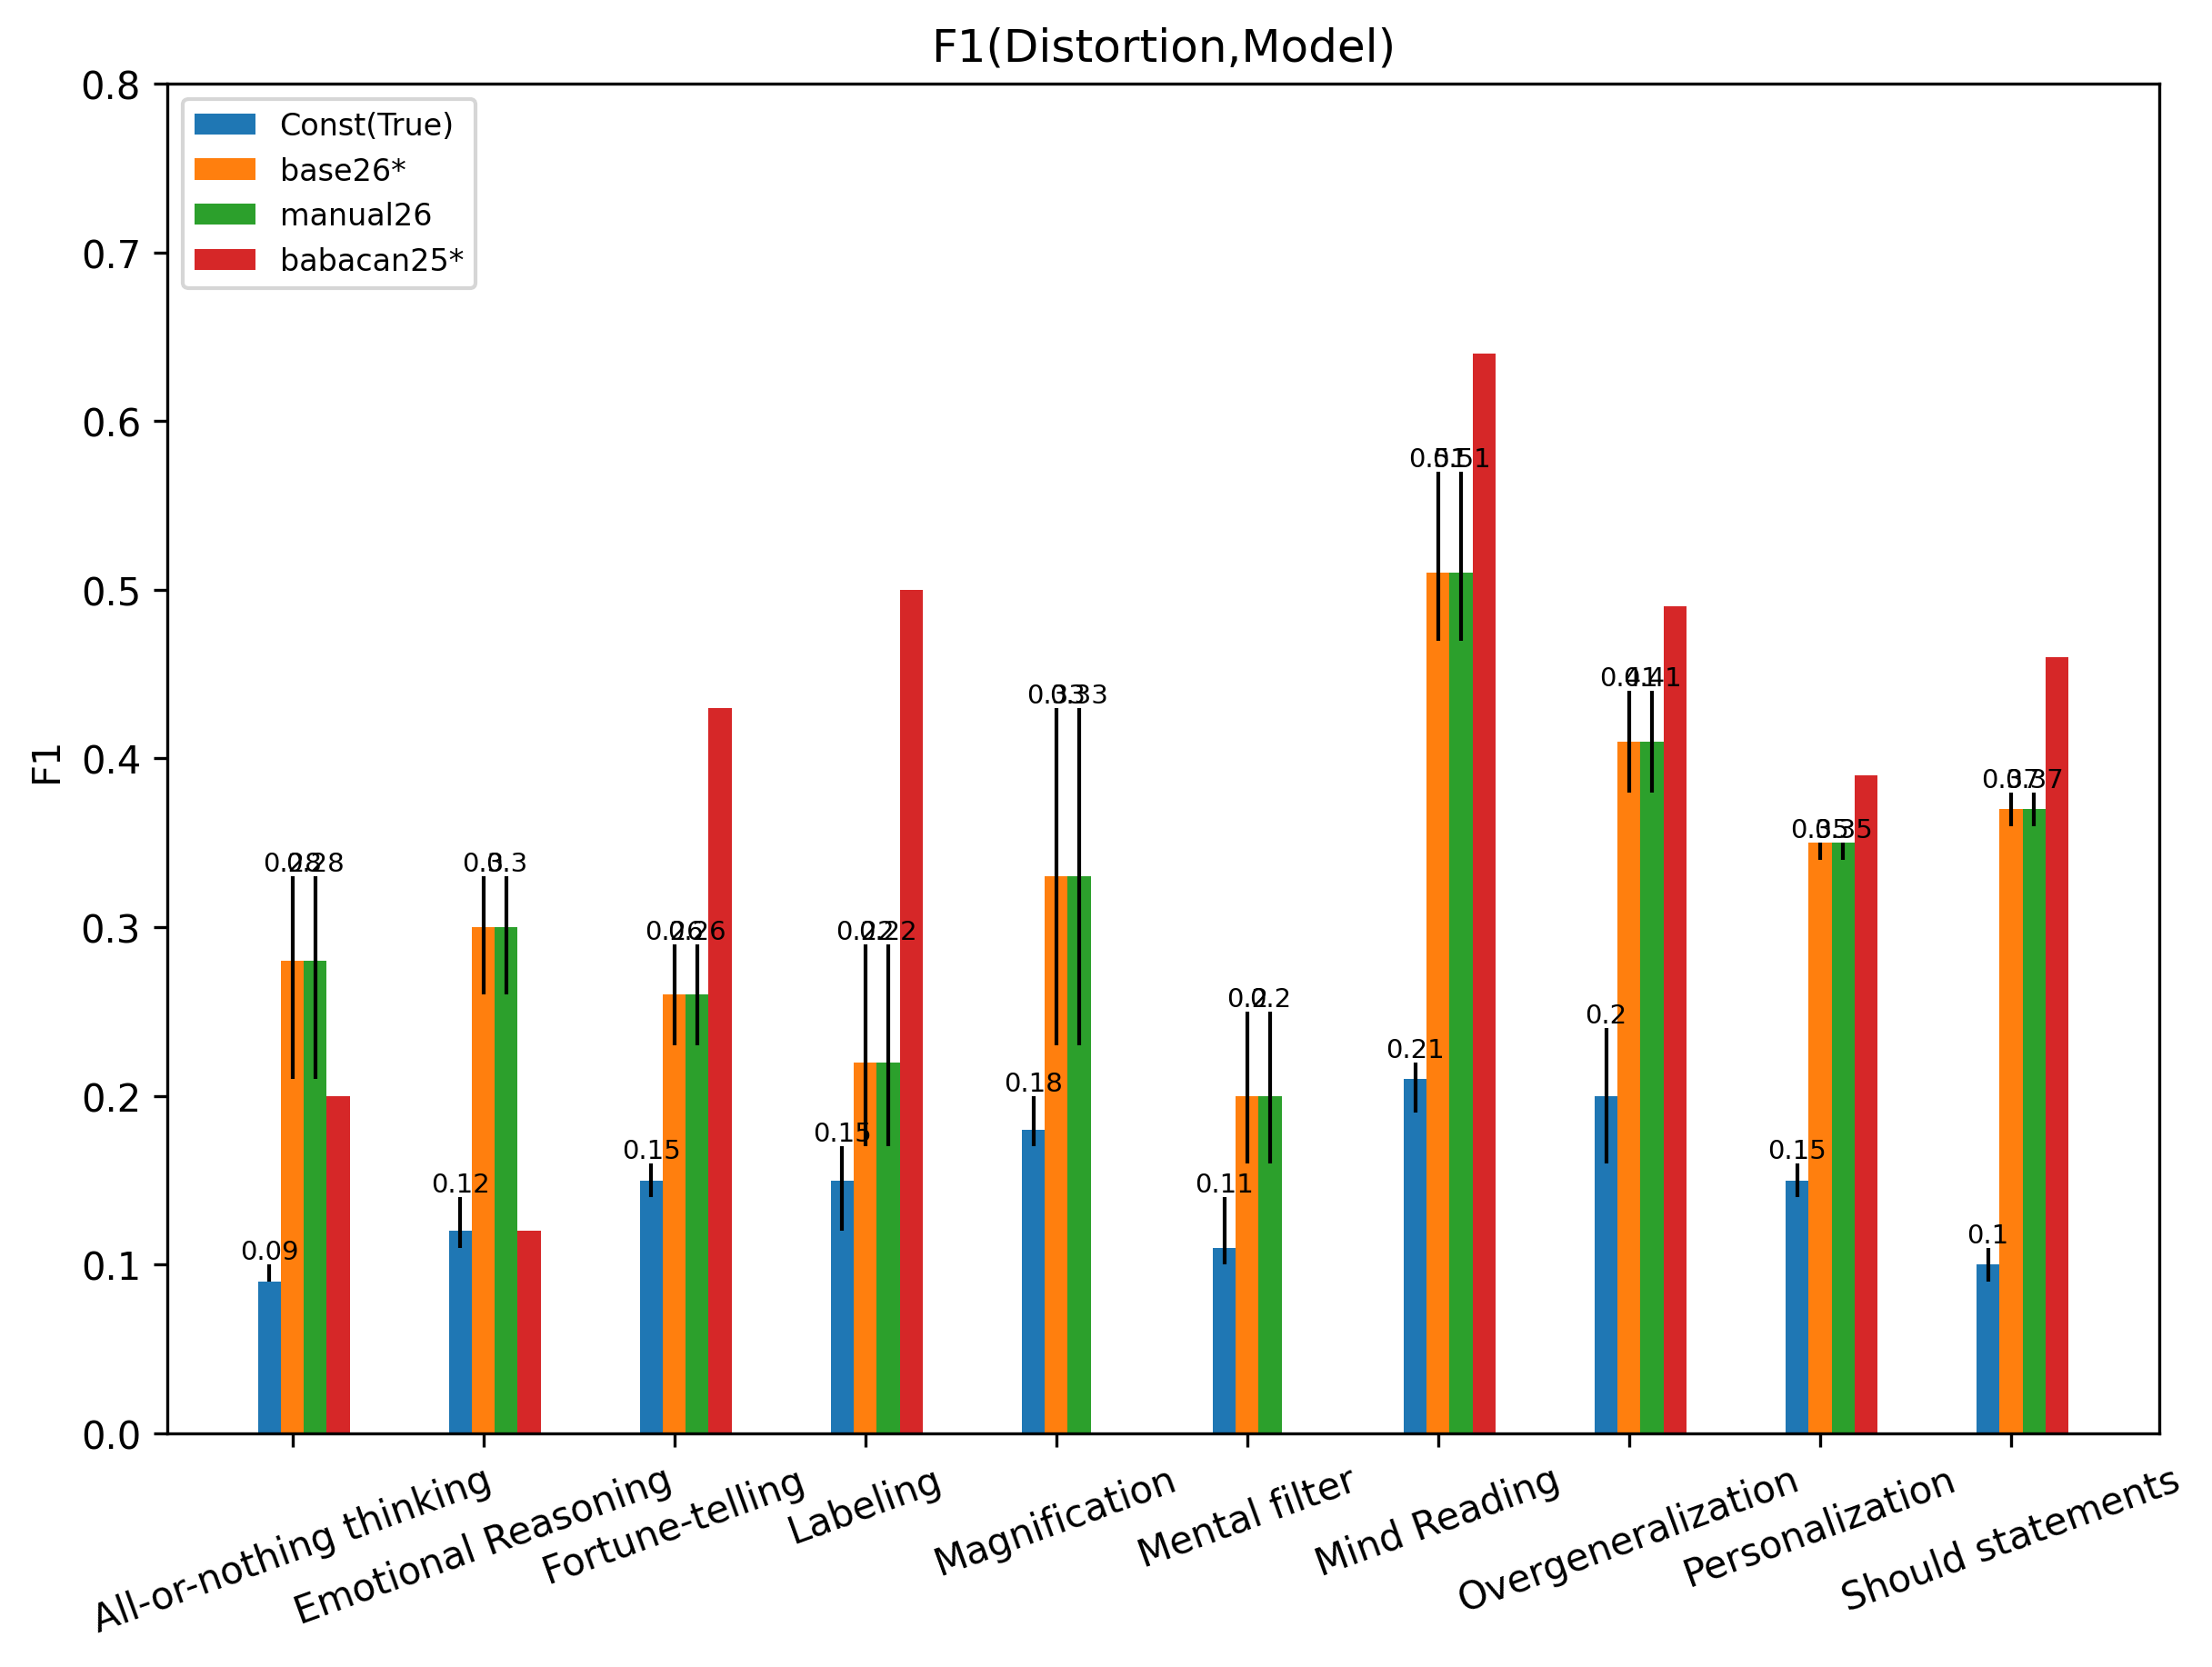

In [24]:
plt.rcParams["figure.figsize"] = (8,6)

x = np.arange(len(labels))  # the label locations
width = 0.12  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',dpi=300)


for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    print(measurement, attribute)
    #ax.bar_label(rects, padding=3, fontsize=7)
    multiplier += 1

all_values = []
all_ranges = []
for m in values:
    for i in range(len(labels)):
        all_values.append(values[m][i])
        all_ranges.append(ranges[m][i])
for p,mm,v in zip(ax.patches,all_ranges,all_values):
            xe = p.get_x()  # get the bottom left x corner of the bar
            w = p.get_width()  # get width of bar
            h = p.get_height()  # get height of bar
            min_y = mm[0]
            max_y = mm[1]
            if min_y < max_y:
                plt.vlines(xe+w/2, min_y, max_y, color='k', linewidth=1)  # draw a vertical line
                plt.text(xe+w/2,max_y,str(round(v,2)),horizontalalignment='center',verticalalignment='bottom', fontsize=7)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1')
ax.set_title('F1(Distortion,Model)')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper left', fontsize=8)
ax.set_ylim(0, 0.8)
ax.tick_params(axis='x', rotation=20)
fig.set_dpi(300)

plt.show()

In [25]:
avgs = []
minmaxs = []
models = list(values)
for m in values:
    vals = values[m]
    avg = round(sum(vals)/len(vals),2)
    minv = min(vals)
    maxv = max(vals)
    avgs.append(avg)
    minmaxs.append((minv,maxv))
    print(avg, m)

# https://dergipark.org.tr/tr/download/article-file/3865878, page 7, Table 5
models.append('babacan25')
avgs.append(0.4467)
minmaxs.append((0.4467,0.4467))

0.15 Const(True)
0.32 base26*
0.32 manual26
0.32 babacan25*


['All-or-nothing thinking', 'Emotional Reasoning', 'Fortune-telling', 'Labeling', 'Magnification', 'Mental filter', 'Mind Reading', 'Overgeneralization', 'Personalization', 'Should statements']
[0.15, 0.32, 0.32, 0.32, 0.4467]
[(0.09, 0.21), (0.2, 0.51), (0.2, 0.51), (0.0, 0.64), (0.4467, 0.4467)]


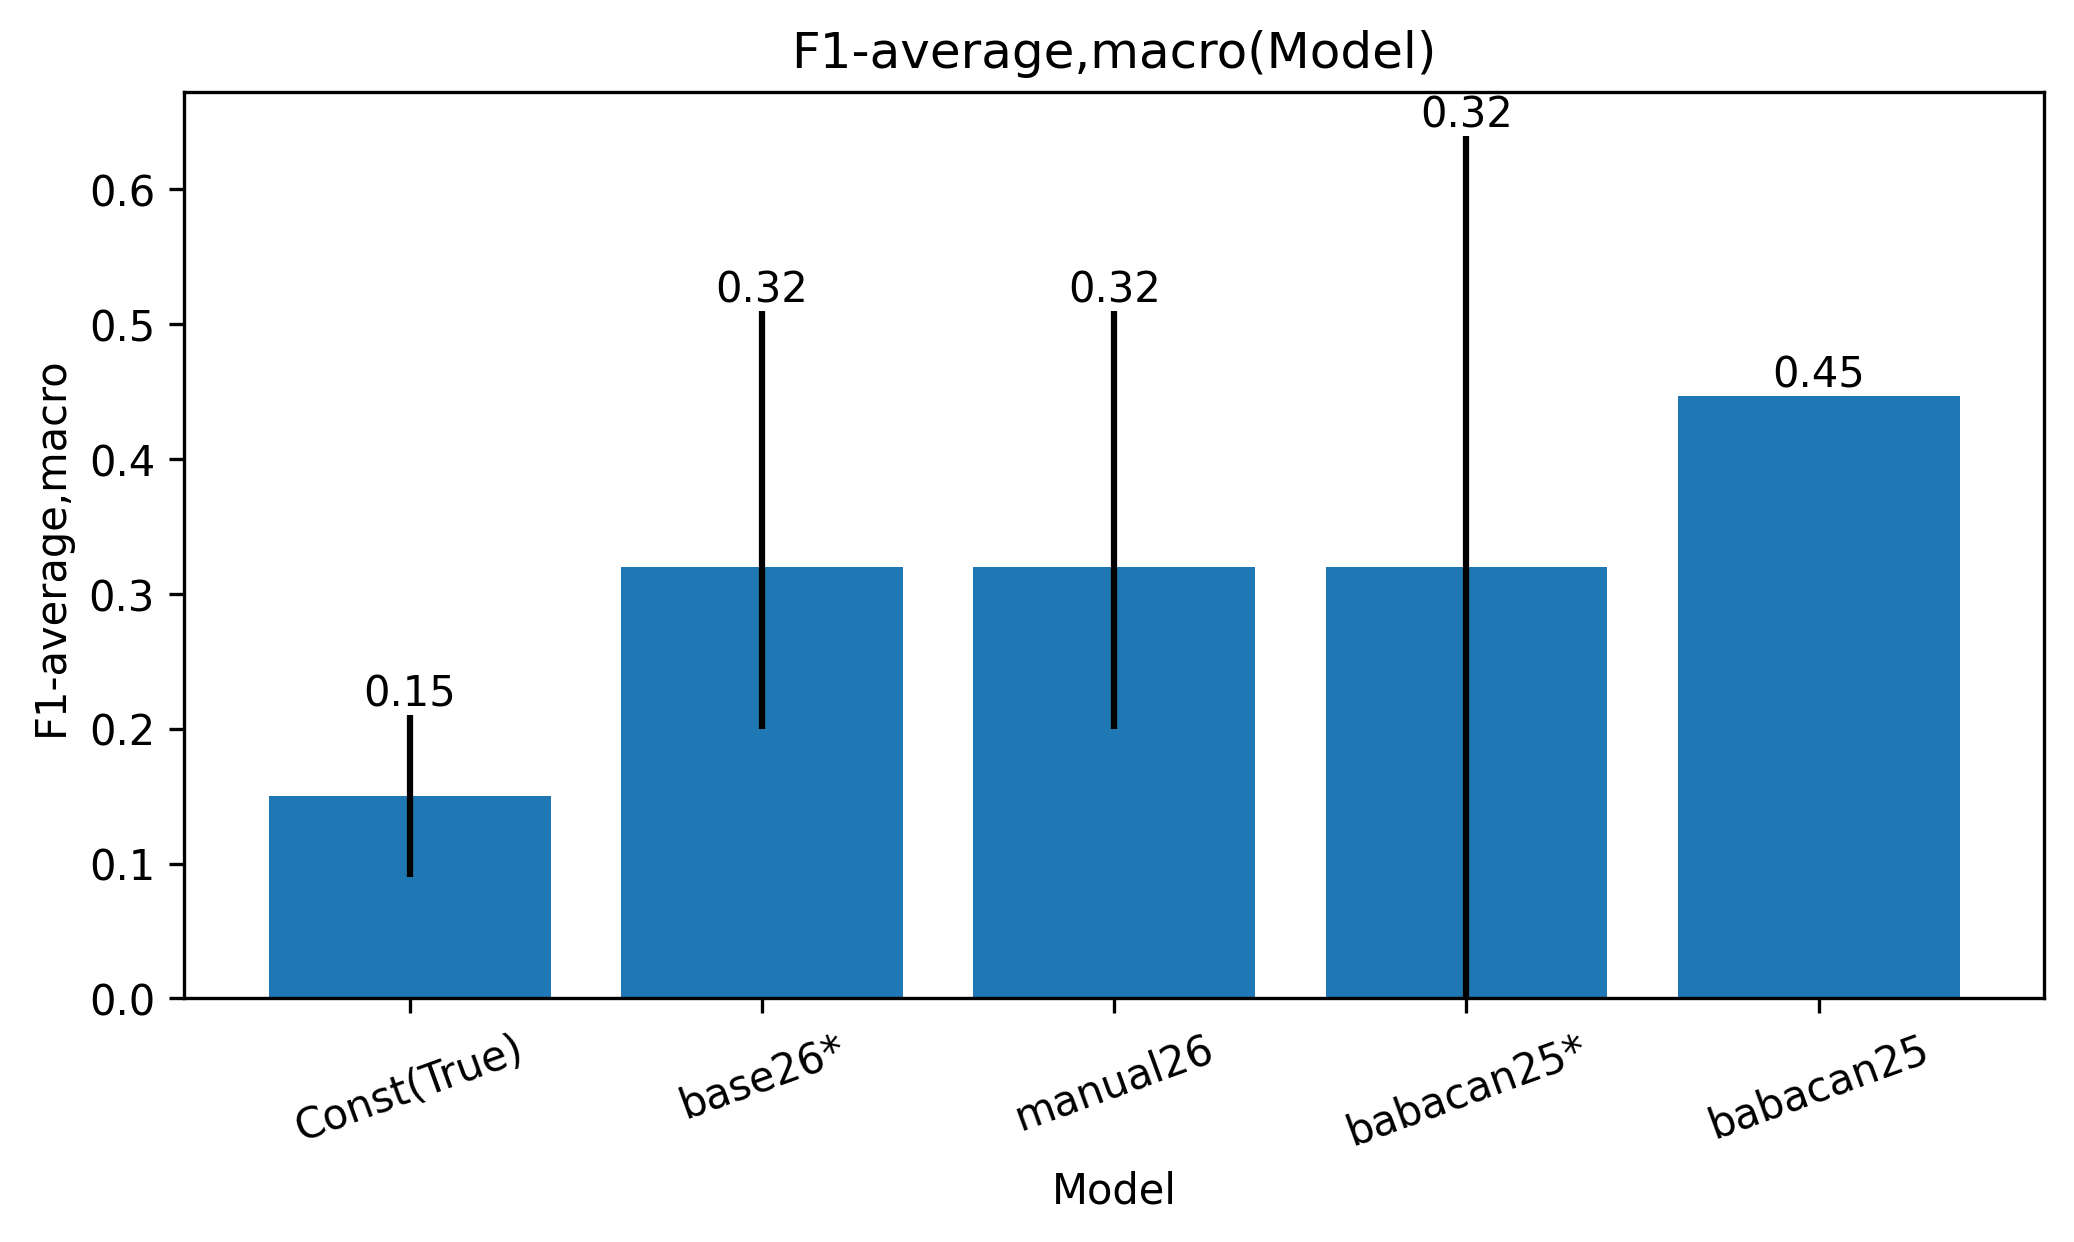

In [26]:
def plot_bar_from_list_minmax(label,labels,value,values,title=None,fontsize=None,minmax=None,dpi=300,x_rotation=0):
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.bar(labels, values)
    plt.title(f'{value}({label})' if title is None else title)
    plt.xlabel(label)
    plt.ylabel(value)
    if x_rotation != 0:
        ax.tick_params(axis='x', rotation=x_rotation)
    if not minmax is None:
        for p,mm,v in zip(ax.patches,minmax,values):
            x = p.get_x()  # get the bottom left x corner of the bar
            w = p.get_width()  # get width of bar
            h = p.get_height()  # get height of bar
            min_y = mm[0]
            max_y = mm[1]
            plt.vlines(x+w/2, min_y, max_y, color='k')  # draw a vertical line
            plt.text(x+w/2,max_y,str(round(v,2)),horizontalalignment='center',verticalalignment='bottom')
    fig.set_dpi(dpi)
    plt.show()


print(labels)
print(avgs)
print(minmaxs)
plot_bar_from_list_minmax('Model',models,'F1-average,macro',avgs,minmax=minmaxs,x_rotation=20)


## Explore cutting the high-frequency unigrams based on Russian lexicon

In [ ]:
with open('./data/dict/ru/lexicon.txt',errors='ignore') as f:
    lines = f.readlines()
    
freqs ={}
for l in lines:
    s = l.split()
    dictcount(freqs,s[0].lower(),int(s[1]))

freqs
print(len(freqs))

In [ ]:
for freq_thesh in [0.10,0.075,0.05,0.025,0.01,0.0075,0.0050,0.0025,0.001]:
    copy = dict_compress_with_loss(freqs.copy(),freq_thesh)
    print(freq_thesh,'\t',len(copy),'\t',round(100*len(copy)/len(freqs),1),'%')
    

In [ ]:
def top_lexicon_by_counts(file,threshold):
    with open(file,errors='ignore') as f:
        lines = f.readlines()
    freqs ={}
    for l in lines:
        s = l.split()
        dictcount(freqs,s[0].lower(),int(s[1]))
    return dict_compress_with_loss(freqs.copy(),threshold)
    

In [ ]:
lex_0_01 = top_lexicon_by_counts('./data/dict/ru/lexicon.txt',0.01)
print(len(lex_0_01))
set(lex_0_01)

In [ ]:
def clean_metrics(tm,scrub_list,debug=False):
    scrub_set = set([(i,) for i in scrub_list]) # index as tuples
    for k in tm.metrics:
        metric = tm.metrics[k]
        for m in list(metric):
            if m in scrub_set:
                metric.remove(m)
                if not tm.weights is None:
                    del tm.weights[k][m]
                if debug:
                    print(k,m)


In [ ]:
model_path = '../../psyhelper/models/ru_manual26'
all_metricsmap = {'All-or-nothing_thinking':'dichotomous-reasoning',
              'Fortune-telling':'fortune-telling',
              'Mental_filter':'mental-filtering',
              'Overgeneralization':'overgeneralizing',
              'Labeling':'labeling',
              'Mind_Reading':'mindreading',
              'Personalization':'personalizing',
              'Emotional_Reasoning':'emotional-reasoning',
              'Magnification':'magnification',
              'Should_statements':'should-statement'}

def language_metrics(lang,metrics_list,path):
    metrics = {}
    for m in metrics_list:
        metrics[m] = path + lang + '/' + metrics_list[m] + '.txt'
    return metrics

for tt in [1.0,0.05,0.04,0.03,0.01]:
    tm_manual = TextMetrics(language_metrics('',all_metricsmap,path=model_path)
                      ,encoding="utf-8",metric_logarithmic=True,debug=False)

    print(tt)
    
    #for m in tm_manual.metrics:
    #    print(len(tm_manual.metrics[m]),m)
    #print()

    clean_metrics(tm_manual,top_lexicon_by_counts('./data/dict/ru/lexicon.txt',tt),True)

    #for m in tm_manual.metrics:
    #    print(len(tm_manual.metrics[m]),m)
    #print()

    dts = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    best_f1 = 0
    besst_dt = 0

    for dt in dts:

        eval_results = []
        for split_shift in split_shifts:
            test_df  = df[(df.index + split_shift) % validation_fraction == 0]
            eval_result = evaluate_tm_df(test_df,tm_manual,our_evaluator_top,dt,all_metrics=list(all_metricsmap),
                        encode_spaces=True,debug=False)
            eval_results.append(eval_result)

        #decode spaces
        new_eval_results = []
        for eval_result in eval_results:
            new_list = []
            for i in [0,1,2,3]:
                dists = {}
                old = eval_result[i]
                for d in old:
                    dists[d.replace('_',' ')] = old[d]
                new_list.append(dists)
            new_eval_results.append(tuple(new_list))
        eval_results = new_eval_results

        #for eval_result in eval_results:
        #    print(eval_result[2]) # F1

        prs = [sum(eval_result[0].values())/len(eval_result[0].values()) for eval_result in eval_results]
        rcs = [sum(eval_result[1].values())/len(eval_result[1].values()) for eval_result in eval_results]
        f1s = [sum(eval_result[2].values())/len(eval_result[2].values()) for eval_result in eval_results]
        pravg = sum(prs)/3
        rcavg = sum(rcs)/3
        f1avg = sum(f1s)/3
        #print(dt,round(pravg,2),round(rcavg,2),round(f1avg,2),[round(x,2) for x in f1s])

        if f1avg > best_f1:
            best_f1 = f1avg
            best_dt = dt
            all_eval_results['manual25*'] = eval_results
    print(best_dt,round(best_f1,2))
    print()


In [27]:
#TODO try min_match_count_threshold

#TODO test binary_mathing?

#TODO test differrent eval function 

#TODO re-deploy the model

#TODO why overgeneralization is missed in model for base26*?
#TODO re-train and re-test 80/20/10 new model

